In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os

tutorial_path = "drive/MyDrive/"
dependencies = f'{tutorial_path}dependencies/'
directory = os.fsencode(f'{dependencies}Chopin')

In [42]:
import pandas as pd
import numpy as np

def timing_3_4():
  three_four_means = [[],[],[]]

  for file in os.listdir(directory):
    filename = os.fsdecode(file)

    annotation = pd.read_csv(f'{dependencies}Chopin/{filename}', sep='\t', header=None)
    if annotation[2].str.contains(pat='3/4').any():
      ind = annotation[2].index[annotation[2].str.contains('3/4')][0]
      end = annotation[2].index[annotation[ind + 1:, 2].str.contains('\d/\d', regex=True)][0] if annotation[2][ind + 1:].str.contains(pat=',\d/\d,').any() else annotation.shape[0] - 1

      three_four_annotations = pd.DataFrame(annotation.loc[ind:end])

      # First average the timings of all the beats in 3/4
      three_four_annotations[1] = three_four_annotations[1].shift(-1, fill_value = 0)

      three_four_annotations.drop(three_four_annotations.tail(1).index, inplace=True)

      # Create a "difference" column
      three_four_annotations[3] = (three_four_annotations[1] - three_four_annotations[0]) * (three_four_annotations[1] - three_four_annotations[0] > 0).astype(float)

      for i in range(3):
        three_four_means[i] += three_four_annotations[3].iloc[i::3].tolist()

  three_four_means = np.array([np.mean(i) for i in three_four_means])
  return 60 / three_four_means


def timing_4_4():
  four_four_means = [[],[],[],[]]

  for file in os.listdir(directory):
    filename = os.fsdecode(file)

    annotation = pd.read_csv(f'{dependencies}Chopin/{filename}', sep='\t', header=None)
    if annotation[2].str.contains(pat='4/4').any():
      ind = annotation[2].index[annotation[2].str.contains('4/4')][0]
      end = annotation[2].index[annotation[ind + 1:, 2].str.contains('\d/\d', regex=True)][0] if annotation[2][ind + 1:].str.contains(pat=',\d/\d,').any() else annotation.shape[0] - 1

      four_four_annotations = pd.DataFrame(annotation.loc[ind:end])

      # First average the timings of all the beats in 4/4
      four_four_annotations[1] = four_four_annotations[1].shift(-1, fill_value = 0)

      four_four_annotations.drop(four_four_annotations.tail(1).index, inplace=True)

      # Create a "difference" column
      four_four_annotations[3] = (four_four_annotations[1] - four_four_annotations[0]) * (four_four_annotations[1] - four_four_annotations[0] > 0).astype(float)

      for i in range(4):
        four_four_means[i] = four_four_annotations[3].iloc[i::4].tolist()

  four_four_means = np.array([np.mean(i) for i in four_four_means])
  return 60 / four_four_means


In [43]:
print("BPM for each beat of 3/4 and 4/4")
three_four_timing = timing_3_4()
four_four_timing = timing_4_4()

print(three_four_timing)
print(four_four_timing)

BPM for each beat of 3/4 and 4/4
[223.61326218 231.98709694 213.28216187]
[59.97264324 63.83040902 61.51163688 58.35315187]


Mapping the unperformed to the performed version using the timing function.

In [44]:
## 3/4 example - Chopin Sonata 2 2nd movement

annotation = pd.read_csv(f'{dependencies}Chopin Unperformed/sonata_2_2nd_unperformed.txt', sep='\t', header=None)

i = 1
beat = 2 # to account for the pickup
while (i < len(annotation)):
  annotation[0].iloc[i] = annotation[0].iloc[i-1] + 60 / three_four_timing[beat]
  annotation[1].iloc[i] = annotation[1].iloc[i-1] + 60 / three_four_timing[beat]

  beat = (beat + 1) % 3
  i += 1

annotation

<ipython-input-44-b09605677fb0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation[0].iloc[i] = annotation[0].iloc[i-1] + 60 / three_four_timing[beat]
<ipython-input-44-b09605677fb0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation[1].iloc[i] = annotation[1].iloc[i-1] + 60 / three_four_timing[beat]


,0,1,2
0,0.000000,0.000000,"b,,-6"
1,0.281317,0.281317,"db,3/4"
2,0.549638,0.549638,b
3,0.808273,0.808273,b
4,1.089590,1.089590,db
...,...,...,...
846,227.932973,227.932973,b
847,228.214290,228.214290,db
848,228.482611,228.482611,b
849,228.741246,228.741246,b


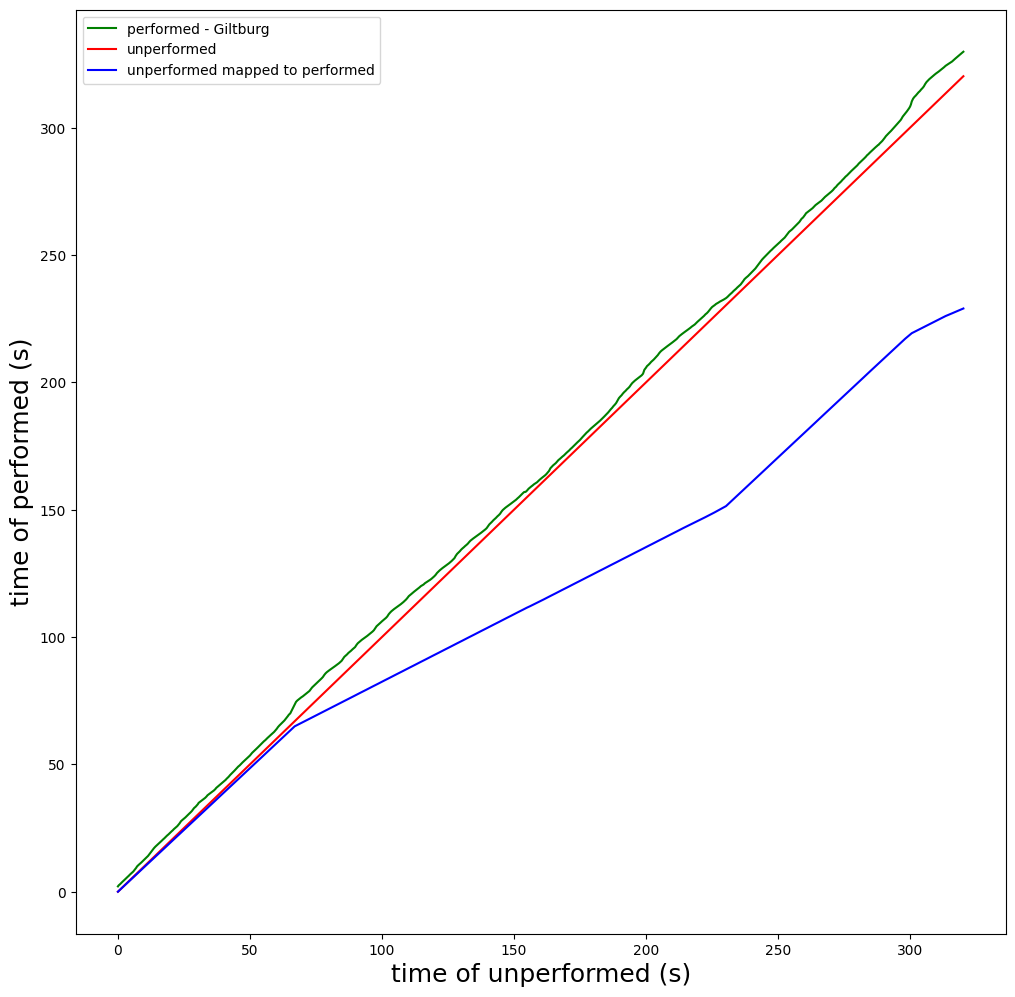

In [45]:
import matplotlib.pyplot as plt

performed = pd.read_csv(f'{dependencies}Chopin/Giltburg02_annotations_2nd.txt', sep='\t', header=None)
unperformed = pd.read_csv(f'{dependencies}Chopin Unperformed/sonata_2_2nd_unperformed.txt', sep='\t', header=None)

fig, ax = plt.subplots(figsize=(12,12))
plt.plot(unperformed[0], performed[0], 'g', label='performed - Giltburg')
plt.plot(unperformed[0], unperformed[0], 'r', label='unperformed')
plt.plot(unperformed[0], annotation[0], 'b', label="unperformed mapped to performed")
plt.xlabel('time of unperformed (s)', fontsize=18)
plt.ylabel('time of performed (s)', fontsize=18)
plt.legend()
plt.show()

In [46]:
## 4/4 example - Chopin Sonata 2 1st movement

annotation = pd.read_csv(f'{dependencies}Chopin Unperformed/sonata_2_1st_unperformed.txt', sep='\t', header=None)

i = 1
beat = 0
while (i < len(annotation)):
  annotation[0].iloc[i] = annotation[0].iloc[i-1] + 60 / four_four_timing[beat]
  annotation[1].iloc[i] = annotation[1].iloc[i-1] + 60 / four_four_timing[beat]

  beat = (beat + 1) % 4
  i += 1

annotation

<ipython-input-46-2f1da8590797>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation[0].iloc[i] = annotation[0].iloc[i-1] + 60 / four_four_timing[beat]
<ipython-input-46-2f1da8590797>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation[1].iloc[i] = annotation[1].iloc[i-1] + 60 / four_four_timing[beat]


,0,1,2
0,0.000000,0.000000,"db,2/2,-5"
1,1.000456,1.000456,b
2,1.940447,1.940447,db
3,2.915872,2.915872,b
4,3.944094,3.944094,db
...,...,...,...
476,469.347219,469.347219,db
477,470.347675,470.347675,b
478,471.287666,471.287666,db
479,472.263091,472.263091,b


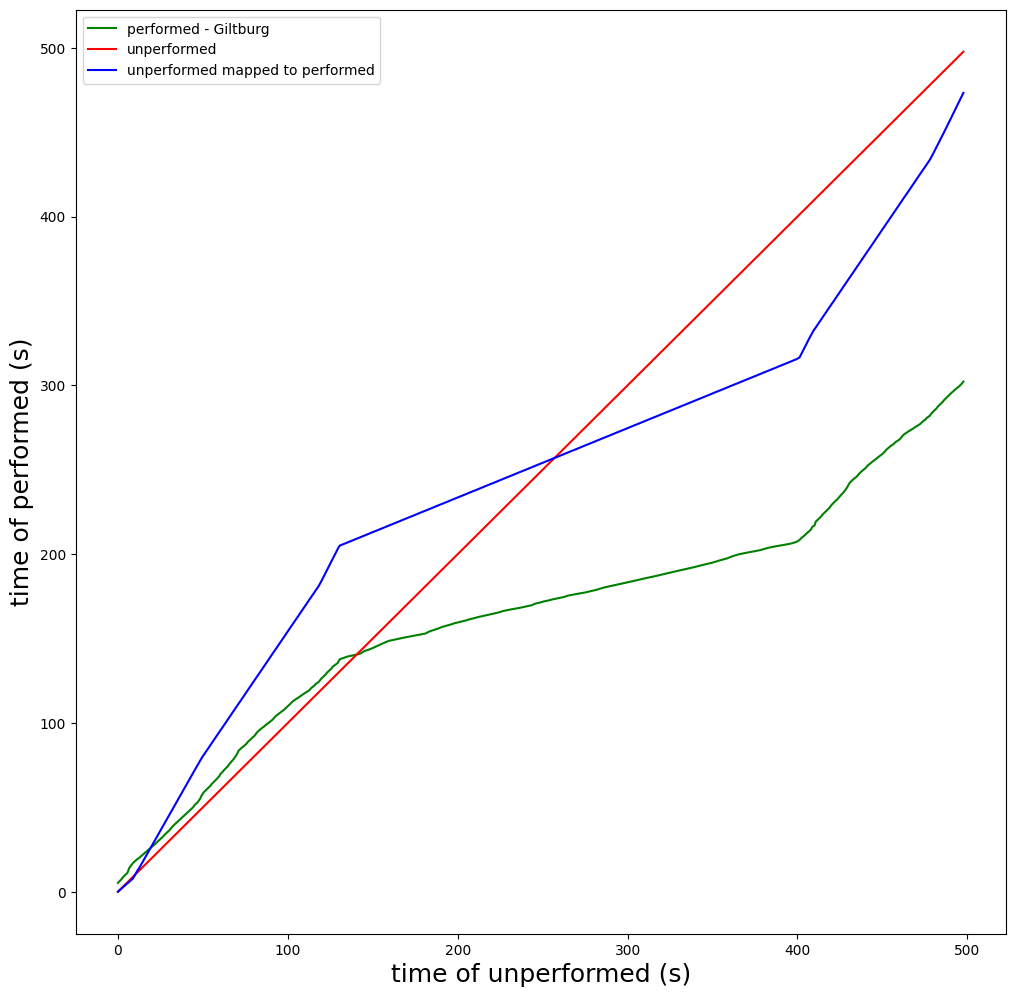

In [48]:
performed = pd.read_csv(f'{dependencies}Chopin/Giltburg02_annotations_1st.txt', sep='\t', header=None)
unperformed = pd.read_csv(f'{dependencies}Chopin Unperformed/sonata_2_1st_unperformed.txt', sep='\t', header=None)

fig, ax = plt.subplots(figsize=(12,12))
plt.plot(unperformed[0], performed[0], 'g', label='performed - Giltburg')
plt.plot(unperformed[0], unperformed[0], 'r', label='unperformed')
plt.plot(unperformed[0], annotation[0], 'b', label="unperformed mapped to performed")
plt.xlabel('time of unperformed (s)', fontsize=18)
plt.ylabel('time of performed (s)', fontsize=18)
plt.legend()
plt.show()